In [162]:
from typing import Union
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import statsmodels.stats.power as smp
from scipy import stats
import statsmodels.api as sm
from econml.dml import LinearDML

In [ ]:
# add bised treatment assignment
# example where speed of test increases because of CUPED
# could we take the min sample and see if we can detect the effect?

### DGP: Pre-experiment data

In [163]:
np.random.seed(123)

n = 10000 # Set number of observations
p = 3 # Set number of pre-experiment covariates

# Create pre-experiment covariates
X = np.random.uniform(size=n * p).reshape((n, -1))

# Nuisance parameters
b = (
    2.0 * X[:, 0] +
    0.5 * X[:, 1] +
    1.5 * X[:, 2]
)

# Calculate outcome
y = b + np.random.normal(size=n)

df = pd.DataFrame({"prev_sales_value": X[:, 0],
                   "prev_sales_freq": X[:, 1],
                   "days_since_sales": X[:, 2],
                   "current_sales_value": y        
})

df

,prev_sales_value,prev_sales_freq,days_since_sales,current_sales_value
0,0.696469,0.286139,0.226851,1.846317
1,0.551315,0.719469,0.423106,3.071748
2,0.980764,0.684830,0.480932,5.115599
3,0.392118,0.343178,0.729050,1.438089
4,0.438572,0.059678,0.398044,2.114989
...,...,...,...,...
9995,0.951586,0.084297,0.293101,1.672212
9996,0.678657,0.634633,0.392566,2.649134
9997,0.273051,0.477273,0.219314,3.083617
9998,0.876315,0.153824,0.980067,1.422551


### Power Analysis

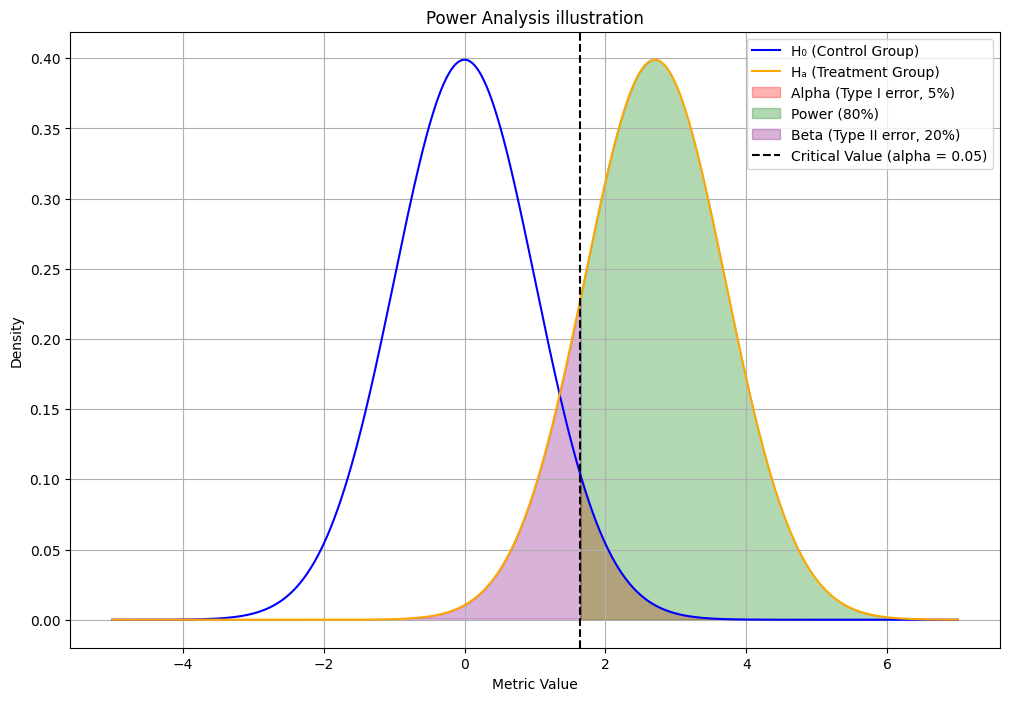

In [207]:
# Parameters
np.random.seed(42)
n = 400 # Sample size per group
effect_size = 2.7  # Larger Cohen's d to make differences clearer
control_mean = 0
treatment_mean = control_mean + effect_size
std_dev = 1
alpha = 0.05
power = 0.8

# Generate data
control_group = np.random.normal(control_mean, std_dev, n)
treatment_group = np.random.normal(treatment_mean, std_dev, n)

# Calculate critical value for alpha
critical_value = stats.norm.ppf(1 - alpha)

# Calculate densities for the control and treatment groups
x = np.linspace(-5, 7, 1000)  # Adjust x range for better visualization with larger effect size
control_density = stats.norm.pdf(x, control_mean, std_dev)
treatment_density = stats.norm.pdf(x, treatment_mean, std_dev)

# Plot density distributions
plt.figure(figsize=(12, 8))
plt.plot(x, control_density, label='H₀ (Control Group)', color='blue')
plt.plot(x, treatment_density, label='Hₐ (Treatment Group)', color='orange')

# Highlight alpha region (Type I error)
x_alpha = np.linspace(critical_value, 7, 100)
y_alpha = stats.norm.pdf(x_alpha, control_mean, std_dev)
plt.fill_between(x_alpha, y_alpha, color='red', alpha=0.3, label='Alpha (Type I error, 5%)')

# Highlight power region (80% power)
x_power = np.linspace(critical_value, 7, 100)
y_power = stats.norm.pdf(x_power, treatment_mean, std_dev)
plt.fill_between(x_power, y_power, color='green', alpha=0.3, label='Power (80%)')

# Highlight beta region (Type II error)
type_II_critical_value = stats.norm.ppf(1 - power)
x_beta = np.linspace(type_II_critical_value, critical_value, 100)
y_beta = stats.norm.pdf(x_beta, treatment_mean, std_dev)
plt.fill_betweenx(y_beta, x_beta, critical_value, color='purple', alpha=0.3, label='Beta (Type II error, 20%)')

# Plot critical value lines
plt.axvline(x=critical_value, color='black', linestyle='--', label='Critical Value (alpha = 0.05)')

# Labels and legend
plt.title('Power Analysis illustration')
plt.xlabel('Metric Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [165]:
# H0 - The density plot shows the variation of this metric if there were no difference between groups. It helps establish a baseline.
# Ha - The density plot shows how the metric varies if there is an actual effect or difference. This is usually shifted relative to the control distribution if the effect size is large.
# Critical value - The critical value is a threshold determined by your significance level and the distribution of the test statistic. It’s used to define the region where you would reject the null hypothesis.
# Type I Error (Alpha) - The red area under the blue curve to the right of the critical value. It shows how often you might mistakenly reject the null hypothesis when it's true.
# Type II Error (Beta) - The purple area under the orange curve between the critical value and the boundary. It shows how often you might mistakenly fail to reject the null hypothesis when the alternative hypothesis is true.
# Power - The green area under the orange curve to the right of the critical value. It shows how effectively the test can detect the effect when the alternative hypothesis is true.
# Larger Sample Size - Leads to a smaller standard deviation for the sampling distribution. The standard error decreases with increasing sample size. With a smaller standard deviation, the distributions of the distributions of H0 and Ha become narrower and less overlapping. This decreased overlap makes it easier to detect a difference, leading to higher power (the probability of correctly rejecting the null hypothesis when the alternative is true).

In [166]:
def power_analysis(metric: Union[np.ndarray, pd.Series], exp_perc_change: float, alpha: float = 0.05, power: float = 0.80) -> int:
    '''
    Perform a power analysis to determine the minimum sample size required for a given metric.

    Args:
        metric (np.ndarray or pd.Series): Array or Series containing the metric values for the control group.
        exp_perc_change (float): The expected percentage change in the metric for the test group.
        alpha (float, optional): The significance level for the test. Defaults to 0.05.
        power (float, optional): The desired power of the test. Defaults to 0.80.

    Returns:
        int: The minimum sample size required for each group to detect the expected percentage change with the specified power and significance level.

    Raises:
        ValueError: If `metric` is not a NumPy array or pandas Series.
    '''
    
    # Validate input types
    if not isinstance(metric, (np.ndarray, pd.Series)):
        raise ValueError("metric should be a NumPy array or pandas Series.")
    
    # Calculate statistics
    control_mean = metric.mean()
    control_std = np.std(metric, ddof=1) # Use ddof=1 for sample standard deviation
    test_mean = control_mean * (1 + exp_perc_change)
    test_std = control_std # Assume the test group has the same standard deviation as the control group
    
    # Calculate (Cohen's D) effect size
    mean_diff = control_mean - test_mean
    pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
    effect_size = abs(mean_diff / pooled_std)  # Cohen's d should be positive
    
    # Run power analysis
    power_analysis = smp.TTestIndPower()
    sample_size = round(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power))
    
    print(f"Control mean: {round(control_mean, 2)}")
    print(f"Control std: {round(control_std, 2)}")
    print(f"Min sample size: {sample_size}")
    
    return sample_size

In [167]:
exp_perc_change = 0.05 # Set the expected percentage change in the chosen metric caused by the treatment

min_sample_size = power_analysis(df["current_sales_value"], exp_perc_change)

Control mean: 2.0
Control std: 1.24
Min sample size: 2398


### DGP: Experiment data

In [168]:
np.random.seed(123)

exp_perc_change = 0.05 # Set the expected percentage change in the chosen metric caused by the treatment

df = pd.DataFrame({"prev_sales_value": X[:, 0],
                   "prev_sales_freq": X[:, 1],
                   "days_since_sales": X[:, 2],
                   "current_sales_value": y        
})

treatment_effect = round((df["current_sales_value"] * (exp_perc_change)).mean(), 2)
treated_samples = min_sample_size

# Create treatment column
treated_indices = np.random.choice(df.index, size=treated_samples, replace=False)
df["treatment"] = 0
df.loc[treated_indices, "treatment"] = 1

# Calculate mean diff before treatment
mean_t0_pre = df[df["treatment"] == 0]["current_sales_value"].mean()
mean_t1_pre = df[df["treatment"] == 1]["current_sales_value"].mean()
mean_diff_pre = round(mean_t1_pre - mean_t0_pre, 2)

# Apply treatment effect
df["result_sales_value"] = df["current_sales_value"]
df.loc[df["treatment"] == 1, "result_sales_value"] = df["current_sales_value"] + treatment_effect

# Calculate mean diff after treatment
mean_t0_post = df[df["treatment"] == 0]["result_sales_value"].mean()
mean_t1_post = df[df["treatment"] == 1]["result_sales_value"].mean()
mean_diff_post  = round(mean_t1_post  - mean_t0_post , 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")

Actual treatment effect: 0.1
Diff-in-means before treatment: -0.03
Diff-in-means after treatment: 0.07


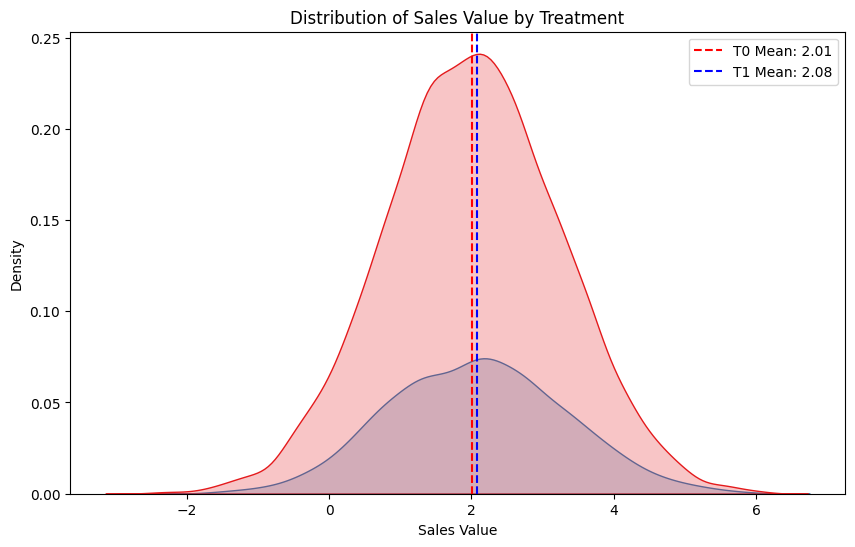

In [169]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="result_sales_value", hue="treatment", fill=True, palette="Set1")
plt.axvline(mean_t0_post , color="red", linestyle="--", label=f"T0 Mean: {mean_t0_post :.2f}")
plt.axvline(mean_t1_post , color="blue", linestyle="--", label=f"T1 Mean: {mean_t1_post :.2f}")
plt.title(f"Distribution of Sales Value by Treatment")
plt.xlabel("Sales Value")
plt.ylabel("Density")

plt.legend()
plt.show()

### ATE: Bootstrapping

In [170]:
def mean_diff(group_a, group_b):
    return np.mean(group_a) - np.mean(group_b)

In [171]:
np.random.seed(42)

group_a = df[df["treatment"] == 1]["result_sales_value"]
group_b = df[df["treatment"] == 0]["result_sales_value"]

res = stats.bootstrap((group_a, group_b), statistic=mean_diff, n_resamples=1000, method='percentile')
ci = res.confidence_interval

bootstrap_means = res.bootstrap_distribution
bootstrap_mean = round(np.mean(bootstrap_means), 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Bootstrap: {bootstrap_mean}")

Actual treatment effect: 0.1
Bootstrap: 0.07


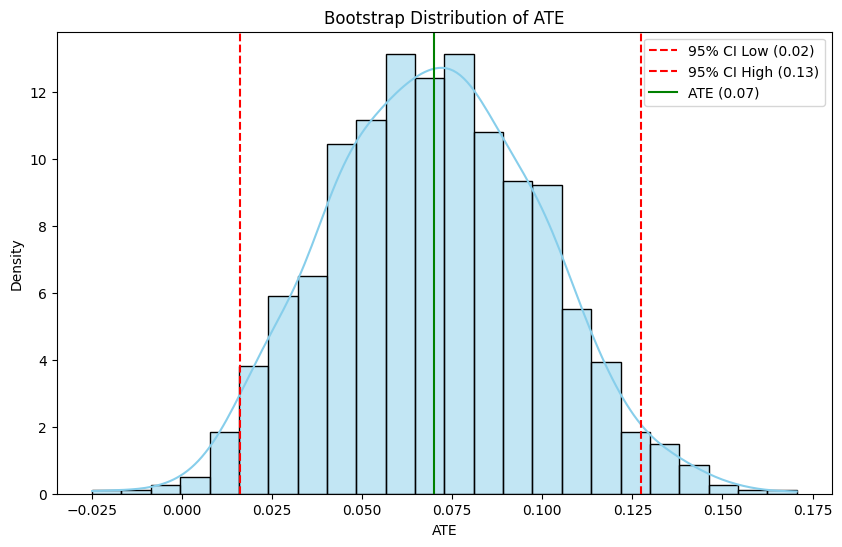

In [172]:
plt.figure(figsize=(10, 6))
    
sns.histplot(bootstrap_means, kde=True, color='skyblue', stat='density')
    
plt.axvline(ci.low, color='red', linestyle='--', label=f'95% CI Low ({ci.low:.2f})')
plt.axvline(ci.high, color='red', linestyle='--', label=f'95% CI High ({ci.high:.2f})')
plt.axvline(bootstrap_mean, color='green', linestyle='-', label=f'ATE ({bootstrap_mean:.2f})')
    
plt.title('Bootstrap Distribution of ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.legend()
    
plt.show()

### Cuped

In [173]:
pre_covariates = ["prev_sales_value", "prev_sales_freq", "days_since_sales"]
target_metric = ["result_sales_value"]

# Fit model using pre-experiment covariates
control_group = df[df['treatment'] == 0]
X_control = control_group[pre_covariates]
X_control = sm.add_constant(X_control)
y_control = control_group[target_metric]

model_control = sm.OLS(y_control, X_control).fit()

# Compute residuals and adjust target metric
X_all = df[pre_covariates]
X_all = sm.add_constant(X_all)
df['residuals'] = df[target_metric].to_numpy().flatten() - model_control.predict(X_all)
df['adjusted_target'] = df['residuals'] + df[target_metric].mean()[0]

# Calculate mean diff after CUPED
mean_t0_adjusted = df[df['treatment'] == 0]['adjusted_target'].mean()
mean_t1_adjusted = df[df['treatment'] == 1]['adjusted_target'].mean()
mean_diff_cuped = round(mean_t1_adjusted - mean_t0_adjusted, 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")
print(f"Diff-in-means after CUPED: {mean_diff_cuped}")

Actual treatment effect: 0.1
Diff-in-means before treatment: -0.03
Diff-in-means after treatment: 0.07
Diff-in-means after CUPED: 0.1


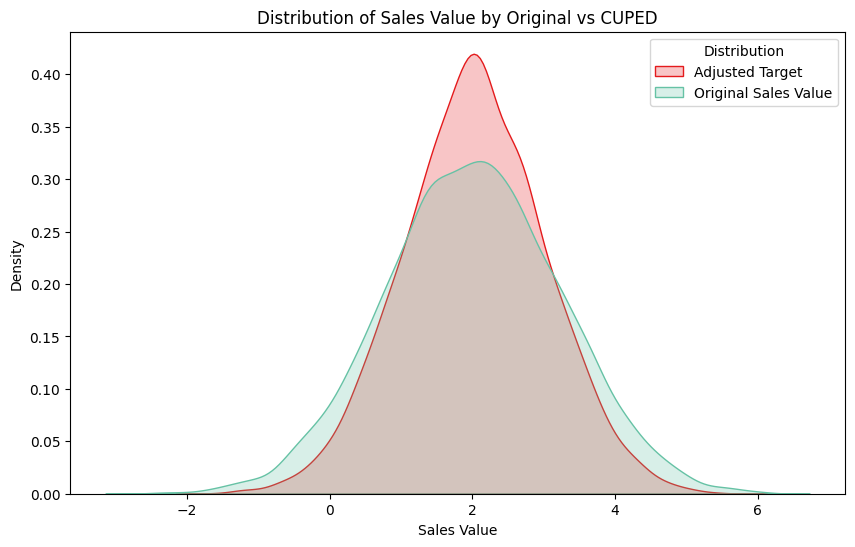

In [174]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['treatment'] == 0], x="adjusted_target", hue="treatment", fill=True, palette="Set1", label="Adjusted Target")
sns.kdeplot(data=df[df['treatment'] == 0], x="result_sales_value", hue="treatment", fill=True, palette="Set2", label="Original Sales Value")
plt.title(f"Distribution of Sales Value by Original vs CUPED")
plt.xlabel("Sales Value")
plt.ylabel("Density")
plt.legend(title="Distribution")

plt.show()

In [175]:
exp_perc_change = treatment_effect / df[df['treatment'] == 0]['adjusted_target'].mean()

cuped_sample_size = power_analysis(df[df['treatment'] == 0]['adjusted_target'], exp_perc_change)

Control mean: 2.03
Control std: 1.0
Min sample size: 1569


### DML

In [176]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df[target_metric].to_numpy().ravel(), T=df['treatment'].to_numpy().ravel(), X=None, W=df[pre_covariates])

# Calculate average treatment effect
ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.1


In [177]:
pre_covariates = ["prev_sales_value", "prev_sales_freq", "days_since_sales"]
target_metric = ["result_sales_value"]

# Fit model outcome model using pre-experiment covariates
X_all = df[pre_covariates]
X_all = sm.add_constant(X)
y_all = df[target_metric]

outcome_model = sm.OLS(y_all, X_all).fit()

# Compute residuals and adjust target metric
df['outcome_residuals'] = df[target_metric].to_numpy().flatten() - outcome_model.predict(X_all)

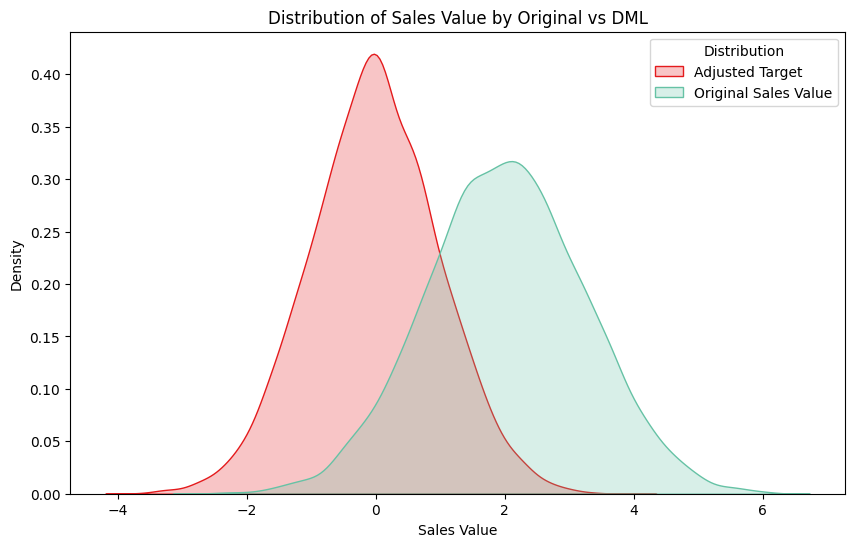

In [178]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['treatment'] == 0], x="outcome_residuals", hue="treatment", fill=True, palette="Set1", label="Adjusted Target")
sns.kdeplot(data=df[df['treatment'] == 0], x="result_sales_value", hue="treatment", fill=True, palette="Set2", label="Original Sales Value")
plt.title(f"Distribution of Sales Value by Original vs DML")
plt.xlabel("Sales Value")
plt.ylabel("Density")
plt.legend(title="Distribution")

plt.show()

In [179]:
exp_perc_change = treatment_effect / df[df['treatment'] == 0]['outcome_residuals'].mean()

cuped_sample_size = power_analysis(df[df['treatment'] == 0]['outcome_residuals'], exp_perc_change)

Control mean: -0.02
Control std: 1.0
Min sample size: 1569


### Heterogeneous treatment effects

In [180]:
np.random.seed(123)

exp_perc_change = 0.05 # Set the expected percentage change in the chosen metric caused by the treatment

df2 = pd.DataFrame({"prev_sales_value": X[:, 0],
                   "prev_sales_freq": X[:, 1],
                   "days_since_sales": X[:, 2],
                   "current_sales_value": y        
})

treatment_effect = round((df2["current_sales_value"] * (exp_perc_change)).mean(), 2)
treated_samples = min_sample_size

# Create treatment column
treated_indices = np.random.choice(df2.index, size=treated_samples, replace=False)
df2["treatment"] = 0
df2.loc[treated_indices, "treatment"] = 1

# Calculate mean diff before treatment
mean_t0_pre = df2[df2["treatment"] == 0]["current_sales_value"].mean()
mean_t1_pre = df2[df2["treatment"] == 1]["current_sales_value"].mean()
mean_diff_pre = round(mean_t1_pre - mean_t0_pre, 2)

# Apply treatment effect
df2["treatment_effect"] = 1
df2.loc[df2["treatment"] == 1, "treatment_effect"] = treatment_effect * 3 * df2["prev_sales_value"] # Heterogenous effect
df2["result_sales_value"] = df2["current_sales_value"]
df2.loc[df2["treatment"] == 1, "result_sales_value"] = df2["current_sales_value"] + df2["treatment_effect"]

# Calculate mean diff after treatment
mean_t0_post = df2[df2["treatment"] == 0]["result_sales_value"].mean()
mean_t1_post = df2[df2["treatment"] == 1]["result_sales_value"].mean()
mean_diff_post  = round(mean_t1_post  - mean_t0_post , 2)

treatment_effect = round(df2[df2["treatment"]==1]["treatment_effect"].mean(), 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")

Actual treatment effect: 0.15
Diff-in-means before treatment: -0.03
Diff-in-means after treatment: 0.12


In [181]:
pre_covariates = ["prev_sales_value", "prev_sales_freq", "days_since_sales"]
target_metric = ["result_sales_value"]

# Fit model using pre-experiment covariates
control_group = df2[df2['treatment'] == 0]
X_control = control_group[pre_covariates]
X_control = sm.add_constant(X_control)
y_control = control_group[target_metric]

model_control = sm.OLS(y_control, X_control).fit()

# Compute residuals and adjust target metric
X_all = df2[pre_covariates]
X_all = sm.add_constant(X_all)
df2['residuals'] = df2[target_metric].to_numpy().flatten() - model_control.predict(X_all)
df2['adjusted_target'] = df2['residuals'] + df2[target_metric].mean()[0]

# Calculate mean diff after CUPED
mean_t0_adjusted = df2[df2['treatment'] == 0]['adjusted_target'].mean()
mean_t1_adjusted = df2[df2['treatment'] == 1]['adjusted_target'].mean()
mean_diff_cuped = round(mean_t1_adjusted - mean_t0_adjusted, 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")
print(f"Diff-in-means after CUPED: {mean_diff_cuped}")

Actual treatment effect: 0.15
Diff-in-means before treatment: -0.03
Diff-in-means after treatment: 0.12
Diff-in-means after CUPED: 0.15


In [182]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df2[target_metric].to_numpy().ravel(), T=df2['treatment'].to_numpy().ravel(), X=None, W=df2[pre_covariates])

# Calculate average treatment effect
ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.15


In [183]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df2[target_metric].to_numpy().ravel(), T=df2['treatment'].to_numpy().ravel(), X=df2[pre_covariates], W=None)

# Calculate average treatment effect
ate_dml = round(dml.ate(df2[pre_covariates]), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.15


### Complex relationships

In [199]:
np.random.seed(123)

n=10000 # Set number of observations
p=10 # Set number of features

# Create features
X = np.random.uniform(size=n * p).reshape((n, -1))

# Nuisance parameters
b = (
    np.sin(np.pi * X[:, 0] * X[:, 1])
    + 2 * (X[:, 2] - 0.5) ** 2
    + X[:, 3]
    + 0.5 * X[:, 4]
    + X[:, 5] * X[:, 6]
    + X[:, 7] ** 3
    + np.sin(np.pi * X[:, 8] * X[:, 9])
)

# Calculate outcome
y = b + np.random.normal(size=n)

df3 = pd.DataFrame({"x0": X[:, 0],
                   "x1": X[:, 1],
                   "x2": X[:, 2],
                   "x3": X[:, 3],
                   "x4": X[:, 4],
                   "x5": X[:, 5],
                   "x6": X[:, 6],                   
                   "x7": X[:, 7],
                   "x8": X[:, 8],                 
                   "x9": X[:, 9],                                                  
                   "current_sales_value": y      
})

df3

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,current_sales_value
0,0.696469,0.286139,0.226851,0.551315,0.719469,0.423106,0.980764,0.684830,0.480932,0.392118,2.267384
1,0.343178,0.729050,0.438572,0.059678,0.398044,0.737995,0.182492,0.175452,0.531551,0.531828,0.940781
2,0.634401,0.849432,0.724455,0.611024,0.722443,0.322959,0.361789,0.228263,0.293714,0.630976,2.895496
3,0.092105,0.433701,0.430863,0.493685,0.425830,0.312261,0.426351,0.893389,0.944160,0.501837,2.318262
4,0.623953,0.115618,0.317285,0.414826,0.866309,0.250455,0.483034,0.985560,0.519485,0.612895,3.533573
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.736133,0.622861,0.244109,0.602192,0.480296,0.974142,0.113963,0.046984,0.209242,0.825644,1.012333
9996,0.609492,0.550516,0.196471,0.553264,0.197432,0.865301,0.044660,0.446605,0.397535,0.342009,2.315585
9997,0.036032,0.580828,0.176889,0.188769,0.201706,0.960395,0.928243,0.359527,0.882122,0.349802,2.933183
9998,0.031554,0.075983,0.111172,0.219915,0.849195,0.656158,0.682321,0.348949,0.106193,0.376015,0.784099


In [211]:
np.random.seed(123)

exp_perc_change = 0.05 # Set the expected percentage change in the chosen metric caused by the treatment

treatment_effect = round((df3["current_sales_value"] * (exp_perc_change)).mean(), 2)
treated_samples = min_sample_size

# Create treatment column
treated_indices = np.random.choice(df3.index, size=treated_samples, replace=False)
df3["treatment"] = 0
df3.loc[treated_indices, "treatment"] = 1

# Calculate mean diff before treatment
mean_t0_pre = df3[df3["treatment"] == 0]["current_sales_value"].mean()
mean_t1_pre = df3[df3["treatment"] == 1]["current_sales_value"].mean()
mean_diff_pre = round(mean_t1_pre - mean_t0_pre, 2)

# Apply treatment effect
df3["result_sales_value"] = df3["current_sales_value"]
df3.loc[df3["treatment"] == 1, "result_sales_value"] = df3["current_sales_value"] + treatment_effect

# Calculate mean diff after treatment
mean_t0_post = df3[df3["treatment"] == 0]["result_sales_value"].mean()
mean_t1_post = df3[df3["treatment"] == 1]["result_sales_value"].mean()
mean_diff_post  = round(mean_t1_post  - mean_t0_post , 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")

Actual treatment effect: 0.12
Diff-in-means before treatment: -0.04
Diff-in-means after treatment: 0.08


In [212]:
pre_covariates = df3.columns[0:10]
target_metric = ["result_sales_value"]

# Fit model using pre-experiment covariates
control_group = df3[df3['treatment'] == 0]
X_control = control_group[pre_covariates]
X_control = sm.add_constant(X_control)
y_control = control_group[target_metric]

model_control = sm.OLS(y_control, X_control).fit()

# Compute residuals and adjust target metric
X_all = df3[pre_covariates]
X_all = sm.add_constant(X_all)
df3['residuals'] = df3[target_metric].to_numpy().flatten() - model_control.predict(X_all)
df3['adjusted_target'] = df3['residuals'] + df3[target_metric].mean()[0]

# Calculate mean diff after CUPED
mean_t0_adjusted = df3[df3['treatment'] == 0]['adjusted_target'].mean()
mean_t1_adjusted = df3[df3['treatment'] == 1]['adjusted_target'].mean()
mean_diff_cuped = round(mean_t1_adjusted - mean_t0_adjusted, 2)

print(f"Actual treatment effect: {treatment_effect}")
print(f"Diff-in-means before treatment: {mean_diff_pre}")
print(f"Diff-in-means after treatment: {mean_diff_post}")
print(f"Diff-in-means after CUPED: {mean_diff_cuped}")

Actual treatment effect: 0.12
Diff-in-means before treatment: -0.04
Diff-in-means after treatment: 0.08
Diff-in-means after CUPED: 0.12


In [213]:
exp_perc_change = treatment_effect / df3[df3['treatment'] == 0]['adjusted_target'].mean()

cuped_sample_size = power_analysis(df3[df3['treatment'] == 0]['adjusted_target'], exp_perc_change)

Control mean: 2.5
Control std: 1.05
Min sample size: 1205


In [214]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df3[target_metric].to_numpy().ravel(), T=df3['treatment'].to_numpy().ravel(), X=None, W=df3[pre_covariates])

# Calculate average treatment effect
ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.12


### Biased treatment assignment